In [1]:
import gym
import numpy as np
import torch
import random
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
#from batchup import data_source


%matplotlib inline
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

In [4]:
env = gym.make('Pendulum-v0')

In [5]:
data = np.zeros((5000,1,128,128))
state = env.reset()
done  = False
for i in range(5000):
    if done:
        state = env.reset()
    image = env.render(mode="rgb_array")
    image = cv2.resize(image, (128,128))
    image = cv2.cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).reshape(1,128,128)
    data[i] = image/255
    state, re, done, _ = env.step(env.action_space.sample())
    
env.close()

XlibException: Could not create UTF8 text property

In [192]:
class ReplayBuffer():
    def __init__(self,max_mem,batch_size,state_dims,action_dims):
        self.memory = max_mem
        self.mem_ctr = 0
        self.mem_full_flag = False
        self.batch_size = batch_size
        self.state_memory = np.zeros((self.memory,state_dims))
        self.next_state_memory = np.zeros((self.memory,state_dims))
        self.action_memory = np.zeros((self.memory,action_dims))
        self.reward_memory = np.zeros(self.memory)
        self.terminal_memory = np.zeros(self.memory)

    def push(self,state,action,reward,next_state,done):
        if self.mem_ctr==self.memory:
            self.mem_full_flag = True
            self.mem_ctr = self.mem_ctr%self.memory
        self.state_memory[self.mem_ctr] = state
        self.action_memory[self.mem_ctr] = action
        self.reward_memory[self.mem_ctr] = reward
        self.terminal_memory[self.mem_ctr] = done
        self.next_state_memory[self.mem_ctr] = next_state

        self.mem_ctr += 1

    def sample(self):
        if self.mem_full_flag:
            current_mem = self.memory
        else:
            current_mem = self.mem_ctr

        batch = np.random.choice(current_mem, self.batch_size, replace = True)
        state_batch = self.state_memory[batch]
        action_batch = self.action_memory[batch]
        reward_batch = self.reward_memory[batch]
        done_batch = self.terminal_memory[batch]
        next_state_batch = self.next_state_memory[batch]


        return state_batch,action_batch,reward_batch,next_state_batch,done_batch
    def __len__(self):
        if self.mem_full_flag:
            return self.memory
        else:
            return self.mem_ctr

In [191]:
class ReplayBuffer:
    def __init__(self, capacity,batch_size,state_dims,action_dims):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
        self.batch_size = batch_size
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self):
        batch = random.sample(self.buffer, self.batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [168]:
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

In [193]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

In [194]:
class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        f1 = 1/np.sqrt(self.linear1.weight.data.size()[0])
        torch.nn.init.uniform_(self.linear1.weight.data,-f1,f1)
        torch.nn.init.uniform_(self.linear1.bias.data,-f1,f1)
        
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        f2 = 1/np.sqrt(self.linear2.weight.data.size()[0])
        torch.nn.init.uniform_(self.linear2.weight.data,-f2,f2)
        torch.nn.init.uniform_(self.linear2.bias.data,-f2,f2)
        
        self.action = nn.Linear(num_actions, hidden_size)
        #f_action = 1/np.sqrt(self.action.weight.data.size()[0])
        #torch.nn.init.uniform_(self.action.weight.data,-f_action,f_action)
        #torch.nn.init.uniform_(self.action.bias.data,-f_action,f_action)
        
        self.linear3 = nn.Linear(hidden_size,1)
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        action = self.action(action)
        x = torch.relu(torch.add(x,action))
        x = self.linear3(x)
        return x

In [195]:
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(PolicyNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        f1 = 1/np.sqrt(self.linear1.weight.data.size()[0])
        torch.nn.init.uniform_(self.linear1.weight.data,-f1,f1)
        torch.nn.init.uniform_(self.linear1.bias.data,-f1,f1)
        
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        f2 = 1/np.sqrt(self.linear2.weight.data.size()[0])
        torch.nn.init.uniform_(self.linear2.weight.data,-f2,f2)
        torch.nn.init.uniform_(self.linear2.bias.data,-f2,f2)
        
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = 3*torch.tanh(self.linear3(x))
        return x
    
    def get_action(self, state):
        state  = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.forward(state)
        return action.detach().cpu().numpy()[0, 0]

In [196]:
def ddpg_update(
           gamma = 0.99,
           min_value=-np.inf,
           max_value=np.inf,
           soft_tau=1e-2):
    
    state, action, reward, next_state, done = replay_buffer.sample()
    
    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    
    policy_loss = value_net(state, policy_net(state))
    policy_loss = -policy_loss.mean()

    next_action    = target_policy_net(next_state)
    target_value   = target_value_net(next_state, next_action.detach())
    expected_value = reward + (1.0 - done) * gamma * target_value
    expected_value = torch.clamp(expected_value, min_value, max_value)

    value = value_net(state, action)
    value_loss = value_criterion(value, expected_value.detach())


    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

    for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

In [197]:
env = gym.make("Pendulum-v0")
ou_noise = OUNoise(env.action_space)
state_dim  = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 128

value_net  = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

target_value_net  = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
target_policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
    target_param.data.copy_(param.data)
    

In [198]:
value_lr  = 1e-3
policy_lr = 1e-4

value_optimizer  = optim.Adam(value_net.parameters(),  lr=value_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)

value_criterion = nn.MSELoss()
batch_size = 128
replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size,batch_size,state_dim,action_dim)

In [199]:
max_frames  = 100000
max_steps   = 1000
n_games = 500
frame_idx   = 0
rewards     = []
batch_size  = 64

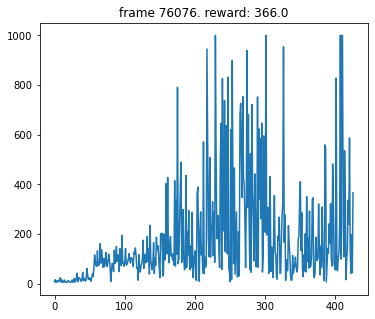

KeyboardInterrupt: 

In [200]:
for i in range(n_games):
    state = env.reset()
    ou_noise.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        action = policy_net.get_action(state)
        action = ou_noise.get_action(action, step)
        next_state, reward, done, _ = env.step(action)
        
        replay_buffer.push(state, action, reward, next_state, done)
        if len(replay_buffer) > batch_size:
            ddpg_update()
        
        state = next_state
        episode_reward += reward
        frame_idx += 1
        if done:
            break
        if (frame_idx)%max(1000,max_steps+1) == 0:
            plot(frame_idx,rewards)
    rewards.append(episode_reward)
    print(episode_reward)